- (c) Ken-ichi Fukui, 2021/02/08
-  MIT License

## ナイーブベイズ分類器によるゴルフプレイデータの識別とROC,AUCによる評価
- データweather.nominal.arffは本プログラムと同じフォルダ内に置いておく
- カテゴリカルナイーブベイズを使用したバージョン

In [4]:
%matplotlib inline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.io import arff
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB

### arffデータの読み込み

In [2]:
f = open("weather.nominal.arff", "r", encoding="utf-8")
data, meta = arff.loadarff(f)
data, meta

(array([(b'sunny', b'hot', b'high', b'FALSE', b'no'),
        (b'sunny', b'hot', b'high', b'TRUE', b'no'),
        (b'overcast', b'hot', b'high', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'high', b'FALSE', b'yes'),
        (b'rainy', b'cool', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'cool', b'normal', b'TRUE', b'no'),
        (b'overcast', b'cool', b'normal', b'TRUE', b'yes'),
        (b'sunny', b'mild', b'high', b'FALSE', b'no'),
        (b'sunny', b'cool', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'normal', b'FALSE', b'yes'),
        (b'sunny', b'mild', b'normal', b'TRUE', b'yes'),
        (b'overcast', b'mild', b'high', b'TRUE', b'yes'),
        (b'overcast', b'hot', b'normal', b'FALSE', b'yes'),
        (b'rainy', b'mild', b'high', b'TRUE', b'no')],
       dtype=[('outlook', 'S8'), ('temperature', 'S4'), ('humidity', 'S6'), ('windy', 'S5'), ('play', 'S3')]),
 Dataset: weather.symbolic
 	outlook's type is nominal, range is ('sunny', 'overcast', 'rainy

### LabelEncoderを使ってラベル特徴を数値に変換
例えば，変数outlookの値{sunny, overcast, rainy}は，{0,1,2}に変換される

In [3]:
le = [LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(),LabelEncoder()]
for idx,attr in enumerate(meta):
    le[idx].fit(list(meta[attr][1]))

class_array = np.array([])
feature_array = np.zeros((0,4))

for x in data:
    w = list(x)
    class_array = np.append(class_array, le[-1].transform(w[-1].decode("utf-8").split()))
    w.pop(-1)
    for idx in range(0, len(w)):
        w[idx] = le[idx].transform(w[idx].decode("utf-8").split())
    temp = np.array(w)
    feature_array = np.append(feature_array, np.ravel(temp).reshape(1,-1), axis=0)

feature_array

array([[2., 1., 0., 0.],
       [2., 1., 0., 1.],
       [0., 1., 0., 0.],
       [1., 2., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [0., 0., 1., 1.],
       [2., 2., 0., 0.],
       [2., 0., 1., 0.],
       [1., 2., 1., 0.],
       [2., 2., 1., 1.],
       [0., 2., 0., 1.],
       [0., 1., 1., 0.],
       [1., 2., 0., 1.]])

### 1つ抜き交差検証（Leave-one-out cross-validation）
全N個のデータから1個を除いた(N-1)個を学習データとしてモデルを学習し，残りの1個でテストを行う．これをN回繰り返す．

In [6]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_array):
    X_train, X_test = feature_array[train_index], feature_array[test_index]
    y_train, y_test = class_array[train_index], class_array[test_index]

    # =====================================================================
    # カテゴリカルナイーブベイズ（CategoricalNB）を使用する．
    # alpha(>0)はスムージングのパラメータ．
    # ただし，等価標本サイズmとの関係はalpha=m/n
    # http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes
    # fit_prior=Trueに指定すると学習データから事前確率を求める．
    # class_priorは，class_prior=[0.2,0.8]の形で事前確率を指定する．fit_prior=Falseのときに有効．
    clf = CategoricalNB(alpha=0.1, class_prior=[0.2,0.8], fit_prior=False)    
    clf.fit(X_train,y_train)

    # =====================================================================
    # 学習データとテストデータに対する各クラスの事後確率を算出
    posterior_trn = clf.predict_proba(X_train)
    posterior_tst = clf.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

True Label: [0.]
Posterior Probability: [[0.83184064 0.16815936]]
True Label: [0.]
Posterior Probability: [[0.94893508 0.05106492]]
True Label: [1.]
Posterior Probability: [[0.4133176 0.5866824]]
True Label: [1.]
Posterior Probability: [[0.88570772 0.11429228]]
True Label: [1.]
Posterior Probability: [[0.39830937 0.60169063]]
True Label: [0.]
Posterior Probability: [[0.006613 0.993387]]
True Label: [1.]
Posterior Probability: [[0.0711119 0.9288881]]
True Label: [0.]
Posterior Probability: [[0.71701019 0.28298981]]
True Label: [1.]
Posterior Probability: [[0.65103176 0.34896824]]
True Label: [1.]
Posterior Probability: [[0.46123992 0.53876008]]
True Label: [1.]
Posterior Probability: [[0.89636828 0.10363172]]
True Label: [1.]
Posterior Probability: [[0.47262957 0.52737043]]
True Label: [1.]
Posterior Probability: [[0.07220863 0.92779137]]
True Label: [0.]
Posterior Probability: [[0.77155298 0.22844702]]


### ROC曲線の描画とAUCの算出

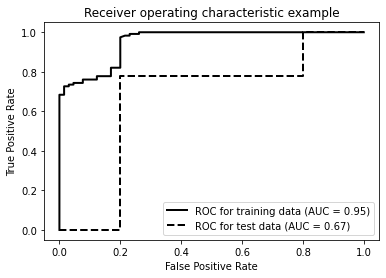

In [7]:
fpr_trn, tpr_trn, thresholds_trn = roc_curve(y_train_list, y_train_post_list)
roc_auc_trn = auc(fpr_trn, tpr_trn)
plt.plot(fpr_trn, tpr_trn, 'k--',label='ROC for training data (AUC = %0.2f)' % roc_auc_trn, lw=2, linestyle="-")

fpr_tst, tpr_tst, thresholds_tst = roc_curve(y_test_list, y_test_post_list)
roc_auc_tst = auc(fpr_tst, tpr_tst)
plt.plot(fpr_tst, tpr_tst, 'k--',label='ROC for test data (AUC = %0.2f)' % roc_auc_tst, lw=2, linestyle="--")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()